In [1]:
%%html
<h2>Keras による RNN実装</h2>
<ul>
  <li>サンプル1</li>
</ul>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(0)

def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise


## データの生成
T = 100
f = toy_problem(T)

length_of_sequences = 2 * T
maxlen = 25  # ひとつの時系列データの長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

## 訓練データと検証データの分割
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

## モデル設定
n_in = len(X[0][0])  # 1
n_hidden = 20
n_out = len(Y[0])  # 1

def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

# early-stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()
# RNNモデル追加
model.add(SimpleRNN(n_hidden,
                    kernel_initializer=weight_variable,
                    input_shape=(maxlen, n_in)))
model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('linear'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

## モデル学習
epochs = 500
batch_size = 10

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[early_stopping])


## 出力を用いて予測
truncate = maxlen
Z = X[:1]  # 元データの最初の一部だけ切り出し

original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences - maxlen + 1):
    # 元データの前時間分のデータ
    z_ = Z[-1:]
    # 予測結果データを計算
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))



Using TensorFlow backend.


Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 0s - loss: 0.5035 - val_loss: 0.3791
Epoch 2/500
158/158 [==============================] - 0s - loss: 0.3934 - val_loss: 0.2549
Epoch 3/500
158/158 [==============================] - 0s - loss: 0.2250 - val_loss: 0.0995
Epoch 4/500
158/158 [==============================] - 0s - loss: 0.0815 - val_loss: 0.0454
Epoch 5/500
158/158 [==============================] - 0s - loss: 0.0500 - val_loss: 0.0733
Epoch 6/500
158/158 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0373
Epoch 7/500
158/158 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0315
Epoch 8/500
158/158 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0288
Epoch 9/500
158/158 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0273
Epoch 10/500
158/158 [==============================] - 0s - loss: 0.0232 - val_loss: 0.0403
Epoch 11/500
158/158 [============

In [3]:
## 評価
"""
https://keras.io/ja/models/sequential/
evaluate(self, x, y, batch_size=32, verbose=1, sample_weight=None)
  バッチごとにある入力データにおける損失値を計算します．
引数
  x: 入力データ，Numpy 配列あるいは Numpy 配列のリスト （モデルに複数の入力がある場合）．
  y: ラベル，Numpy 配列．
  batch_size: 整数で，指定したサンプル数で勾配の更新を行います．
  verbose: 進行状況メッセージ出力モードで，0か1．
  sample_weight: サンプルの重み，Numpy 配列．

戻り値
  スカラーで，テストデータの損失値（モデルの評価関数を設定していない場合） あるいは
  スカラーのリスト（モデルが他の評価関数を計算している場合）． 
  model.metrics_names属性により，スカラーの出力でラベルを表示します．
"""
score = model.evaluate(X_validation, Y_validation, batch_size=batch_size,verbose=0)
print("score:", score)

score: 0.00168743668797


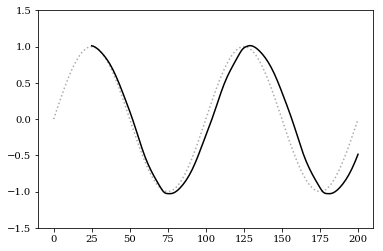

In [4]:
'''
グラフで可視化
'''
plt.rc('font', family='serif')
plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
#plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()